In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import random

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from scipy.optimize import differential_evolution

In [2]:
import os
dataset = pd.read_csv(os.path.join(os.getcwd(), 'data/pima_indian_data.csv'))

# creating input features and target variables
X = np.asarray(dataset.iloc[:,0:8], dtype=np.float32)
y = np.asarray(dataset.iloc[:,8], dtype=np.float32)

#standardizing the input feature
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
num_features = X_train.shape[1]

# Train with RF
rf = RandomForestClassifier(n_estimators=25, random_state=3)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)
# Train with LR
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
# predict probabilities
lr_probs = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
lr_probs = lr_probs[:, 1]

RF: ROC AUC=0.853
LS: ROC AUC=0.858


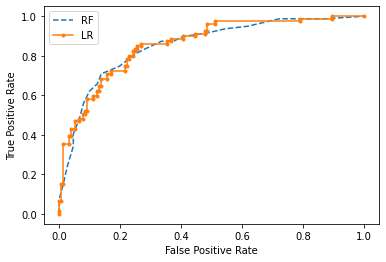

In [3]:
# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('RF: ROC AUC=%.3f' % (rf_auc))
print('LS: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(rf_fpr, rf_tpr, linestyle='--', label='RF')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LR')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot



# ConeOpt

In [4]:
print("ER (train) = {}".format(sum(y_train)/len(y_train)))
print("ER (test) = {}".format(sum(y_test)/len(y_test)))
#np.select(y_test == 1, y_test)

# get current point and reference point 
idx_y_test_pos = np.argwhere(y_test == 1).flatten()
idx_y_test_neg = np.argwhere(y_test == 0).flatten()

idx_curr = idx_y_test_pos[5]
idx_ref = idx_y_test_neg[4]

print("=" * 80)
X_curr = X_test[idx_curr:idx_curr+1, :]
print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
print("X (curr) = ", X_curr)

print("=" * 80)
X_ref = X_test[idx_ref:idx_ref+1, :]
print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
print("X (ref) = ", X_ref)




ER (train) = 0.35074626865671643
ER (test) = 0.341991341991342
Y (curr) has prob =  [0.73912398]
X (curr) =  [[-1.1405786   2.1322243   1.8030151   0.28113997 -0.69355917  0.2929392
  -0.1107037   0.6625124 ]]
Y (ref) has prob =  [0.54667594]
X (ref) =  [[ 2.7185016  -0.4649656   0.04641078 -1.2868819  -0.69355917  0.28025538
  -0.66612315  1.5991105 ]]


In [5]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#r108fc14fa019-1

def run_coneopt(X_curr, X_ref, max_step = 0.3, fixed_features = []):

    print("=" * 80)
    X_cone = X_ref - X_curr
    print("Cone = ",  X_cone)

    bounds = list(zip(X_curr.flatten(), (X_curr + X_cone * max_step).flatten()))
    for b in range(len(bounds)):
        bound = bounds[b]
        if bound[0] > bound[1]:
            bounds[b] = bound[1], bound[0]

    for idx_feat in fixed_features:
        bounds[idx_feat] = (X_curr[0][idx_feat], X_curr[0][idx_feat])
    print("Bounds = ", bounds)

    #print(X_curr, X_curr + X_cone * max_step)

    def my_predict_proba(x, method):
        return method.predict_proba(x.reshape(1, len(x)))[:, 1]

    result = differential_evolution(
        func=my_predict_proba, 
        bounds=bounds, 
        args=[lr],
        disp=True,
        seed=0)
    X_opt = result.x.reshape(1, len(result.x))

    print("=" * 80)
    print("CURR")
    print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
    print("X (curr) = ", X_curr)

    print("=" * 80)
    print("OPT")
    print("Y (opt) has prob = ", lr.predict_proba(X_opt)[:, 1])
    print("X (opt) = ", X_opt)

    print("=" * 80)
    print("REF")
    print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
    print("X (ref) = ", X_ref)

    print("=" * 80)
    
    return X_opt
    
    
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#r108fc14fa019-1

def run_coneopt2(X_curr, X_ref, max_step = 0.3, fixed_features = []):

    print("=" * 80)
    X_cone = X_ref - X_curr
    print("Cone = ",  X_cone)

    bounds = list(zip(X_curr.flatten(), (X_curr + X_cone * max_step).flatten()))
    for b in range(len(bounds)):
        bound = bounds[b]
        if bound[0] > bound[1]:
            bounds[b] = bound[1], bound[0]

    bounds2 = []
    fixed_x = []
    non_fixed_features = []
    for b in range(len(bounds)):
        if b not in set(fixed_features):
            bounds2.append(bounds[b])
            non_fixed_features.append(b)
        else:
            fixed_x.append(X_curr[0][b]) 
    num_features = len(bounds)
    bounds = bounds2
    num_features_active = len(bounds)
    print("Bounds = ", bounds)
    print("fixed_features = ", fixed_features)
    print("fixed_x = ", fixed_x)
    print("non_fixed_features = ", non_fixed_features)

    #print(X_curr, X_curr + X_cone * max_step)

    def get_full_x(non_fixed_x, fixed_features, non_fixed_features, fixed_x):
        full_x = [b for b in range(len(fixed_features) + len(non_fixed_features))]
        for b in range(len(non_fixed_features)):
            full_x[non_fixed_features[b]] = non_fixed_x[b]
        for b in range(len(fixed_features)):
            full_x[fixed_features[b]] = fixed_x[b]
        return full_x

    def my_predict_proba(non_fixed_x, method, fixed_features, non_fixed_features, fixed_x):
        if non_fixed_features == []:
            return method.predict_proba(x.reshape(1, len(x)))[:, 1]
        else:
            full_x = get_full_x(non_fixed_x, fixed_features, non_fixed_features, fixed_x)
            #print("non_fixed_features", non_fixed_features)
            #print("fixed_features", fixed_features)
            return method.predict_proba(np.array(full_x).reshape(1, len(full_x)))[:, 1]

    result = differential_evolution(
        func=my_predict_proba, 
        bounds=bounds, 
        args=[lr, fixed_features, non_fixed_features, fixed_x],
        disp=True,
        seed=0)
    
    full_x = get_full_x(result.x, fixed_features, non_fixed_features, fixed_x)
    X_opt = np.array(full_x).reshape(1, len(full_x))

    print("=" * 80)
    print("CURR")
    print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
    print("X (curr) = ", X_curr)

    print("=" * 80)
    print("OPT")
    print("Y (opt) has prob = ", lr.predict_proba(X_opt)[:, 1])
    print("X (opt) = ", X_opt)

    print("=" * 80)
    print("REF")
    print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
    print("X (ref) = ", X_ref)

    print("=" * 80)
    
    return X_opt
        

In [6]:
def identify_fixed_features(
    X_curr,
    X_opt,
    influential_features_percentage = 0.5, 
    delta_feature_eps = 0.0001):

    # Identify the most influential features -- 50% of the most important features.
    #influential_features_percentage = 0.5 
    #delta_feature_eps = 0.0001
    
    num_features = X_curr.shape[1]
    diff = list(map(abs, X_opt.flatten() - X_curr.flatten()))
    for i in range(len(diff)):
        if diff[i] == 0:
            diff[i] += random.randrange(100)*delta_feature_eps
    num_features_changed = sum(np.array(diff) > delta_feature_eps)

    num_target_features = int(max(1, influential_features_percentage * num_features_changed))
    print("Will use [{}] feautres for the analysis".format(num_target_features))

    #print("diff", diff)
    #print("list(map(abs, X_curr))", list(map(abs, X_curr)))
    delta_changes = np.divide(diff, list(map(abs, X_curr)))[0]
    print("delta_changes = ", delta_changes)
    cutoff_feature_value = sorted(delta_changes, reverse = True)[num_target_features - 1]
    print("Cutoff feature values (only feature with values >= cutoff will be included) = {}".format(cutoff_feature_value))
    flag_required_feature = delta_changes >= cutoff_feature_value
    
    #print(idx_required_feature)
    assert(sum(flag_required_feature) == num_target_features)
    
    return [i for i in range(num_features) if flag_required_feature[i]==False]
    


In [7]:
max_step = 0.35

X_opt_init = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=[])
fixed_features = identify_fixed_features(X_curr, X_opt_init)
print(fixed_features)

#X_opt = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)
X_opt = run_coneopt2(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)
#X_opt = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)


Cone =  [[ 3.8590803  -2.59719    -1.7566043  -1.5680219   0.         -0.01268381
  -0.55541945  0.93659806]]
Bounds =  [(-1.1405786, 0.21009946), (1.223208, 2.1322243), (1.1882036, 1.8030151), (-0.2676677, 0.28113997), (-0.69355917, -0.69355917), (0.28849986, 0.2929392), (-0.3051005, -0.1107037), (0.6625124, 0.99032176)]
differential_evolution step 1: f(x)= 0.535521
differential_evolution step 2: f(x)= 0.533366
differential_evolution step 3: f(x)= 0.533366
differential_evolution step 4: f(x)= 0.531819
differential_evolution step 5: f(x)= 0.531819
differential_evolution step 6: f(x)= 0.530634
differential_evolution step 7: f(x)= 0.52867
differential_evolution step 8: f(x)= 0.525298
differential_evolution step 9: f(x)= 0.524621
differential_evolution step 10: f(x)= 0.523298
differential_evolution step 11: f(x)= 0.523298
differential_evolution step 12: f(x)= 0.519777
differential_evolution step 13: f(x)= 0.519777
differential_evolution step 14: f(x)= 0.519777
differential_evolution step 

C:\Users\foundation\research\ColinML\ConeOpt\conda_env\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
C:\Users\foundation\research\ColinML\ConeOpt\conda_env\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
